In [1]:
import transformers
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor
import PIL
import requests
import glob
import os
from scipy import spatial
from IPython.display import Image, display
import pandas as pd
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

/Users/carlalasry/opt/anaconda3/envs/venv_vit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def load_image(image_filename):
    # print(image_filename)
    image = PIL.Image.open(image_filename)
    return image

In [3]:
def load_images_folder(folder_path):
    images = []
    for img_filename in tqdm(os.listdir(folder_path)):
        if img_filename==".DS_Store":
            continue
        img = load_image(os.path.join(folder_path, img_filename))
        images.append(img)
    return images

In [4]:
def process_input(images_list, processor):
    inputs = processor(images=images_list, return_tensors="pt")
    [img.close() for img in images_list]
    return inputs

In [5]:
def get_vit_features(model, inputs):
    outputs = model(**inputs)
    logits = outputs.logits
    return logits

In [6]:
def get_cosine_similarity_for_two_images(features_1, features_2):
    # cosine similarity
    cosine_similarity = 1 - spatial.distance.cosine(features_1, features_2)
    return cosine_similarity

In [7]:
def get_mahattan_similarity_for_two_images(features_1, features_2):
    # cosine similarity
    mahattan_similarity = 1 - spatial.distance.cityblock(features_1, features_2)
    return mahattan_similarity

In [8]:
def get_filenames(source_dir):
    l = os.listdir(source_dir)
    if ".DS_Store" in l:
        l.remove(".DS_Store")
    return l

In [9]:
def get_number_tps(df_results):
    c_tps = 0
    res_tps = [] 
    c_fps = 0 
    res_fps = []
    for row in df_results.iterrows():
        cap_id = row[0].split("_")[0]
        sess_id = row[1]["max"].split("_")[0]
        if cap_id == sess_id:
            c_tps += 1
            if df_results.loc[row[0]][row[1]["max"]] == 0:
                c_tps = c_tps - 1
            else:
                res_tps.append((row[0],row[1]["max"], df_results.loc[row[0]][row[1]["max"]]))
        else:
            if df_results.loc[row[0]][row[1]["max"]] == 0:
                continue
            else:
                c_fps += 1
                res_fps.append((row[0],row[1]["max"], df_results.loc[row[0]][row[1]["max"]]))
    return c_tps, c_fps, res_tps, res_fps

In [10]:
def get_all_results(caps_filenames, caps_images, outputs_caps, streams_filenames, streams_images, outputs_streams):
    results = {}
    for cap_filename, cap_img, cap in zip(caps_filenames, caps_images, outputs_caps):
        cap_sess_id = cap_filename.split("_")[0]
        results[cap_sess_id] = {}
        for stream_filename, stream_img, stream in zip(streams_filenames, streams_images, outputs_streams):
            cosine_similarity = get_cosine_similarity_for_two_images(cap.tolist(), stream.tolist())
            stream_sess_id = stream_filename.split("_")[0]
            results[cap_sess_id][stream_sess_id] = cosine_similarity
    return results

In [11]:
def get_percentile_tp(df_results):
    df_new = df_results.copy()
    df_new.drop(["max"],axis=1, inplace=True)
    df_new["index_tp"] = 10000
    df_new["score_tp"] = 10000
    df_new["max_score_fp"] = 10000
    
    for row in df_new.iterrows():
        cap_id = row[0].split("_")[0]
        columns_sorted = row[1].drop(["index_tp"]).sort_values(ascending=False).index
        sessions_sorted = [s.split("_")[0] for s in columns_sorted]
        index_tp = sessions_sorted.index(cap_id)
        sess_id = [s for s in columns_sorted.values if s.split("_")[0]==cap_id][0]
        df_new.loc[row[0], "index_tp"]= (index_tp/len(df_new))
        max_score_fp = df_results.loc[row[0]].drop([sess_id, "max"]).max()
        df_new.loc[row[0], "score_tp"] = df_new.loc[row[0], sess_id]
        df_new.loc[row[0], "max_score_fp"] = max_score_fp
    return df_new


In [79]:
def get_tps_fps_percentage(dict_df_filtered):
    dict_results = {}
    for key in dict_df_filtered.keys():
        new_key = key.split("_")[0]
        dict_results[new_key] = dict_df_filtered[key]
    tps = 0
    fps = 0
    for key in dict_results.keys():
        for stream in dict_results[key]:
            stream_id = stream.split("_")[0]
            if key == stream_id:
                tps += 1
            else:
                fps+=1
    return tps, fps

In [12]:
caps_filenames = get_filenames("/Users/carlalasry/Desktop/captures_tps_2200/")

In [14]:
# streams_filenames = get_filenames("/Users/carlalasry/Desktop/streams_tps_500/")
streams_filenames = get_filenames("/Users/carlalasry/Desktop/streams_tps_2200/")

In [58]:
results_vit = pd.read_csv("dataframes/results_500_tps.csv", index_col=0).T

In [18]:
results_vit['max'] = results_vit.idxmax(axis=1)


In [19]:
c_tps_vit, c_fps_vit, res_tps_vit, res_fps_vit = get_number_tps(results_vit)

In [20]:
c_tps_vit

56

In [59]:
results_beit = pd.read_csv("dataframes/results_500_tps_microsoft_model.csv", index_col=0).T

In [22]:
results_beit.shape

(500, 500)

In [23]:
results_beit['max'] = results_beit.idxmax(axis=1)

In [24]:
c_tps_beit, c_fps_beit, res_tps_beit, res_fps_beit = get_number_tps(results_beit)

In [25]:
c_tps_beit

308

In [27]:
#vgg results
with open("dataframes/similarity_captures_tps_500.txt","r") as f:
    scores = f.readlines()
f.close()

In [28]:
#vgg results
with open("dataframes/crop_names_captures_tps_500.txt", "r") as f :
    caps_names = f.readlines()
f.close()

In [29]:
caps_filenames = [s.split("\n")[0].split("/")[-1] for s in caps_names]

In [30]:
with open("dataframes/crop_names_streams_tps_500.txt", "r") as f :
    streams_names = f.readlines()
f.close()

In [31]:
streams_filenames = [s.split("\n")[0].split("/")[-1] for s in streams_names]

In [32]:
len(scores)

500

In [33]:
results_vgg = {}
for cap_filename, row in zip(caps_filenames, scores):
    results_vgg[cap_filename] = {}
    res_cap = [float(i) for i in row.split(" ")]
    for stream_filename, res_stream in zip(streams_filenames, res_cap):
        results_vgg[cap_filename][stream_filename] = res_stream


In [34]:
results_vgg_df = pd.DataFrame(results_vgg).T
results_vgg_df['max'] = results_vgg_df.idxmax(axis=1)

In [35]:
results_vgg_df.head(3)

,1714355952657977300_16001_1679703488.328.png,1714356269034246100_10801_1679703569.923.png,1714357401798414300_10801_1679703845.348.png,1714357520291696600_12101_1679703870.264.png,1714357689242460200_23005_1679703891.497.png,1714358212238626800_10803_1679704007.01.png,1714358610416373800_10801_1679704137.812.png,1714358794839920600_23005_1679704169.145.png,1714358801567682600_10801_1679704179.114.png,1714358918416814000_12101_1679704202.466.png,...,1715105380574445600_10822_1679882179.513.png,1715106440919740400_24011_1679882437.075.png,1715107071214579700_10803_1679882576.061.png,1715107093930872800_10803_1679882590.158.png,1715109820773765000_10802_1679883229.754.png,1715110031000694800_10803_1679883281.203.png,1715111400826781700_10803_1679883593.581.png,1715114281671946200_10822_1679884301.918.png,1715116363258884000_10822_1679884794.066.png,max
1714355952657977300_ID_0-4.png,0.863235,0.290689,0.270108,0.200694,0.231299,0.509019,0.321986,0.377792,0.261638,0.325761,...,0.212210,0.164542,0.408088,0.444396,0.382760,0.271967,0.377349,0.317538,0.177663,1714355952657977300_16001_1679703488.328.png
1714356269034246100_ID_0-1.png,0.386154,0.432476,0.406210,0.426972,0.293492,0.421415,0.356443,0.361301,0.332526,0.332523,...,0.346148,0.208014,0.414277,0.370783,0.326335,0.407620,0.394826,0.363656,0.274016,1715059653789991000_10805_1679871271.036.png
1714357401798414300_ID_0-5.png,0.278915,0.651589,0.767603,0.453510,0.568061,0.506802,0.620626,0.508122,0.635678,0.377384,...,0.652619,0.191091,0.444601,0.532003,0.344746,0.780464,0.392942,0.348681,0.484468,1715070872315871200_10803_1679873924.078.png


In [36]:
c_tps_vgg, c_fps_vgg, res_tps_vgg, res_fps_vgg = get_number_tps(results_vgg_df)

In [37]:
c_tps_vgg

206

In [42]:
percentiles_results_vgg = get_percentile_tp(results_vgg_df)

Text(0.5, 1.0, 'Percentage true positive for VGG')

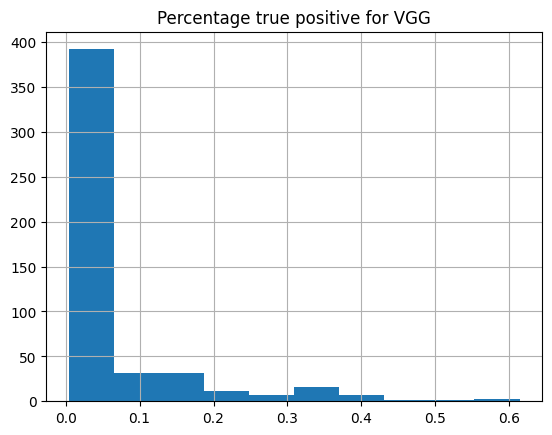

In [44]:
percentiles_results_vgg["index_tp"].hist()
plt.title("Percentage true positive for VGG")

In [45]:
percentiles_results_vit = get_percentile_tp(results_vit)

Text(0.5, 1.0, 'Percentage true positive for ViT')

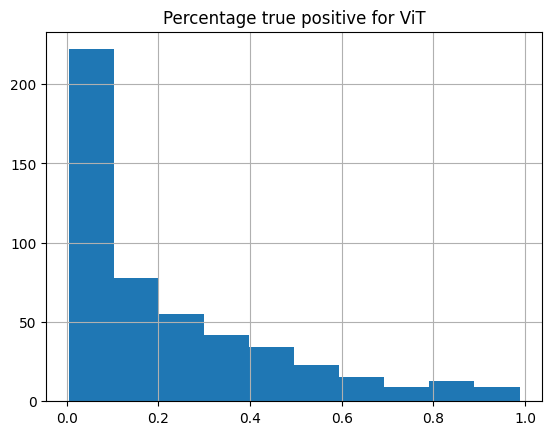

In [46]:
percentiles_results_vit["index_tp"].hist()
plt.title("Percentage true positive for ViT")

In [47]:
percentiles_results_beit = get_percentile_tp(results_beit)

Text(0.5, 1.0, 'Percentage true positive for BEiT')

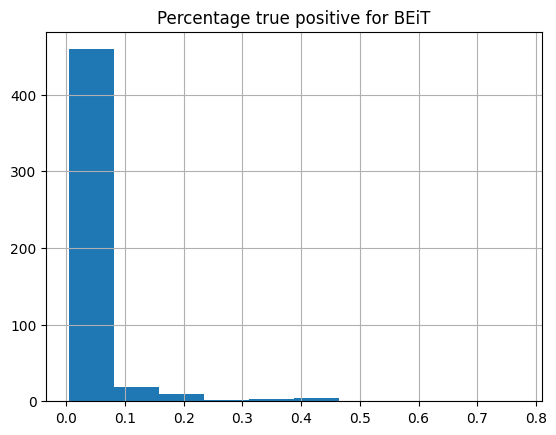

In [48]:
percentiles_results_beit["index_tp"].hist()
plt.title("Percentage true positive for BEiT")

In [50]:
percentiles_results_beit["score_tp"].min()

0.186088361182739

In [51]:
percentiles_results_vit["score_tp"].min()

0.0783244855854052

In [52]:
percentiles_results_vgg["score_tp"].min()

0.30710822

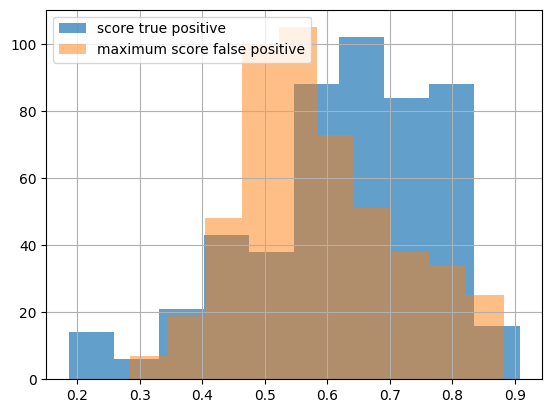

In [53]:
percentiles_results_beit["score_tp"].hist(alpha=0.7, label="score true positive")
percentiles_results_beit["max_score_fp"].hist(alpha=0.5, label="maximum score false positive")
plt.legend()

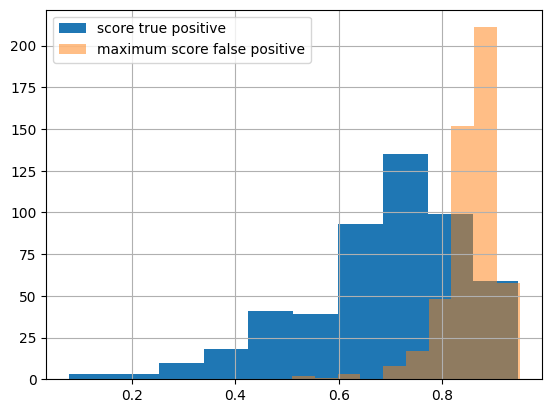

In [54]:
percentiles_results_vit["score_tp"].hist(label="score true positive")
percentiles_results_vit["max_score_fp"].hist(alpha=0.5, label="maximum score false positive")
plt.legend()

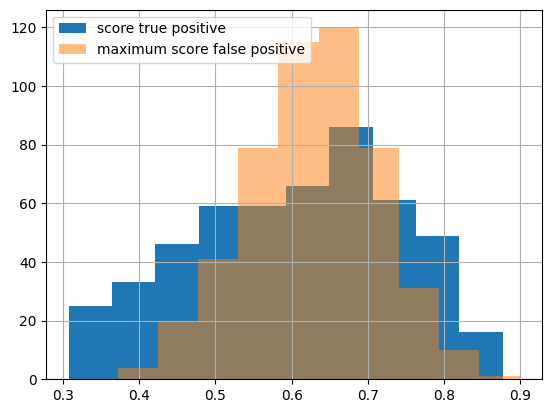

In [55]:
percentiles_results_vgg["score_tp"].hist(label="score true positive")
percentiles_results_vgg["max_score_fp"].hist(alpha=0.5, label="maximum score false positive")
plt.legend()

# Analysis on about 2200 pairs of TPs

In [60]:
results_vit_2200 = pd.read_csv("dataframes/results_2200_tps_vit_model.csv", index_col=0).T

In [61]:
results_beit_2200 = pd.read_csv("dataframes/results_2200_tps_beit_model.csv", index_col=0).T

In [62]:
results_clip_2200 = pd.read_csv("dataframes/results_tps_2200_clip_similarity.csv", index_col=0).T

In [63]:
results_vit_2200['max'] = results_vit_2200.idxmax(axis=1)
results_beit_2200['max'] = results_beit_2200.idxmax(axis=1)
results_clip_2200['max'] = results_clip_2200.idxmax(axis=1)

In [66]:
#VGG results on 2200 pairs
with open("dataframes/similarity_captures_tps_2200.txt","r") as f:
    scores = f.readlines()
f.close()
with open("dataframes/crop_names_captures_tps_2200.txt", "r") as f :
    caps_names = f.readlines()
f.close()
with open("dataframes/crop_names_streams_tps_2200.txt", "r") as f :
    streams_names = f.readlines()
f.close()


caps_filenames = [s.split("\n")[0].split("/")[-1] for s in caps_names]
streams_filenames = [s.split("\n")[0].split("/")[-1] for s in streams_names]

results_vgg_2200 = {}
for cap_filename, row in zip(caps_filenames, scores):
    results_vgg_2200[cap_filename] = {}
    res_cap = [float(i) for i in row.split(" ")]
    for stream_filename, res_stream in zip(streams_filenames, res_cap):
        results_vgg_2200[cap_filename][stream_filename] = res_stream


results_vgg_df_2200 = pd.DataFrame(results_vgg_2200).T
results_vgg_df_2200['max'] = results_vgg_df_2200.idxmax(axis=1)

In [67]:
c_tps_vit, c_fps_vit, res_tps_vit, res_fps_vit = get_number_tps(results_vit_2200)
c_tps_beit, c_fps_beit, res_tps_beit, res_fps_beit = get_number_tps(results_beit_2200)
c_tps_clip, c_fps_clip, res_tps_clip, res_fps_clip = get_number_tps(results_clip_2200)
c_tps_vgg, c_fps_vgg, res_tps_vgg, res_fps_vgg = get_number_tps(results_vgg_df_2200)


print(c_tps_vit/len(results_vit_2200))
print(c_tps_beit/len(results_beit_2200))
print(c_tps_clip/len(results_clip_2200))
print(c_tps_vgg/len(results_vgg_df_2200))

In [69]:
baseline_tps = 0.5714285714285714
baseline_fps = 0.42857142857142855

# Could this help in filtering?

# here we can play with thresholds

# VIT

In [ ]:
results_vit_2200_filtered =results_vit_2200
results_vit_2200_filtered = results_vit_2200_filtered.drop(columns=['max'])

In [88]:
for col in results_vit_2200_filtered.columns:
    results_vit_2200_filtered.loc[results_vit_2200_filtered[col]> 0.95, col] = True
    results_vit_2200_filtered.loc[results_vit_2200_filtered[col] != True, col] = False


In [89]:
results_vit_2200_filtered["cap_id"] = results_vit_2200_filtered.index

/var/folders/xw/0gkws3qn6qv_gtp1mz6xgvzw0000gn/T/ipykernel_28309/1945064018.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_vit_2200_filtered["cap_id"] = results_vit_2200_filtered.index


In [90]:
out_d_vit = results_vit_2200_filtered.melt('cap_id').query('value').groupby('cap_id')['variable'].agg(list).to_dict()


In [869]:
tps_vit, fps_vit = get_tps_fps_percentage(out_d_vit)

In [ ]:
total_vit = results_vit_2200_filtered.shape[0]*results_vit_2200_filtered.shape[0]

tps_vit/total_vit

In [91]:
fps_vit

NameError: name 'fps_vit' is not defined

# BEiT

In [ ]:
results_beit_2200_filtered = results_beit_2200
results_beit_2200_filtered = results_beit_2200_filtered.drop(columns=['max'])

In [82]:
for col in results_beit_2200_filtered.columns:
    results_beit_2200_filtered.loc[results_beit_2200_filtered[col]> 0.87, col] = True
    results_beit_2200_filtered.loc[results_beit_2200_filtered[col] != True, col] = False


In [83]:
results_beit_2200_filtered["cap_id"] = results_beit_2200_filtered.index

/var/folders/xw/0gkws3qn6qv_gtp1mz6xgvzw0000gn/T/ipykernel_28309/2214421695.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_beit_2200_filtered["cap_id"] = results_beit_2200_filtered.index


In [108]:
out_d_beit = results_beit_2200_filtered.melt('cap_id').query('value').groupby('cap_id')['variable'].agg(list).to_dict()


In [ ]:
tps_beit, fps_beit = get_tps_fps_percentage(out_d_beit)

In [ ]:
tps_beit

In [ ]:
fps_beit

In [ ]:
total_beit = results_beit_2200_filtered.shape[0]*results_beit_2200_filtered.shape[0]

fps_beit/total_beit

# CLIP

In [ ]:
results_clip_2200_filtered = results_clip_2200
results_clip_2200_filtered = results_clip_2200_filtered.drop(columns=['max'])

In [84]:
for col in results_clip_2200_filtered.columns:
    results_clip_2200_filtered.loc[results_clip_2200_filtered[col]> 0.94, col] = True
    results_clip_2200_filtered.loc[results_clip_2200_filtered[col] != True, col] = False


In [85]:
results_clip_2200_filtered["cap_id"] = results_clip_2200_filtered.index

/var/folders/xw/0gkws3qn6qv_gtp1mz6xgvzw0000gn/T/ipykernel_28309/1988590872.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_clip_2200_filtered["cap_id"] = results_clip_2200_filtered.index


In [62]:
out_d_clip = results_clip_2200_filtered.melt('cap_id').query('value').groupby('cap_id')['variable'].agg(list).to_dict()

In [63]:
tps_clip, fps_clip = get_tps_fps_percentage(out_d_clip)

In [65]:
tps_clip

1

In [884]:
total_clip = results_clip_2200_filtered.shape[0]*results_clip_2200_filtered.shape[0]

fps_clip/total_clip

4.362181568081037e-05

# VGG

In [135]:
results_vgg_2200_filtered = results_vgg_df_2200
results_vgg_2200_filtered = results_vgg_2200_filtered.drop(columns=['max'])

In [136]:
for col in results_vgg_2200_filtered.columns:
    results_vgg_2200_filtered.loc[results_vgg_2200_filtered[col]< 0.29, col] = True
    results_vgg_2200_filtered.loc[results_vgg_2200_filtered[col] != True, col] = False

In [137]:
results_vgg_2200_filtered["cap_id"] = results_vgg_2200_filtered.index

/var/folders/xw/0gkws3qn6qv_gtp1mz6xgvzw0000gn/T/ipykernel_21796/2958985192.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_vgg_2200_filtered["cap_id"] = results_vgg_2200_filtered.index


In [138]:
out_d_vgg = results_vgg_2200_filtered.melt('cap_id').query('value').groupby('cap_id')['variable'].agg(list).to_dict()


In [139]:
tps_vgg, fps_vgg = get_tps_fps_percentage(out_d_vgg)

In [141]:
total_vgg = results_vgg_2200_filtered.shape[0]*results_vgg_2200_filtered.shape[0]

fps_vgg / total_vgg

0.31443934914686095

In [ ]:
# Some more analysis

In [53]:
percentiles_results_vit_2200 = get_percentile_tp(results_vit_2200)
percentiles_results_beit_2200 = get_percentile_tp(results_beit_2200)
percentiles_results_vgg_2200 = get_percentile_tp(results_vgg_df_2200)

Text(0.5, 1.0, 'Percentage true positive for ViT on more than 2200 pairs')

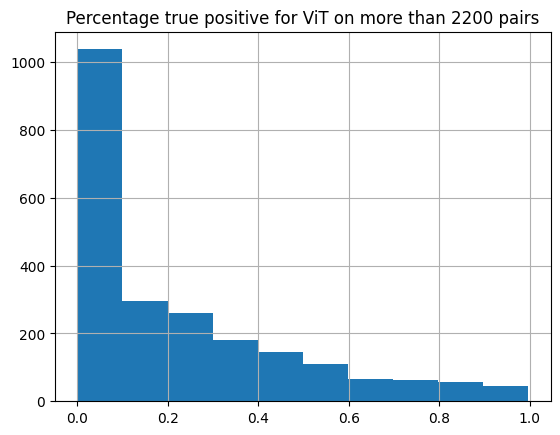

In [29]:
percentiles_results_vit_2200["index_tp"].hist()
plt.title("Percentage true positive for ViT on more than 2200 pairs")

Text(0.5, 1.0, 'Percentage true positive for BEiT on more than 2200 pairs')

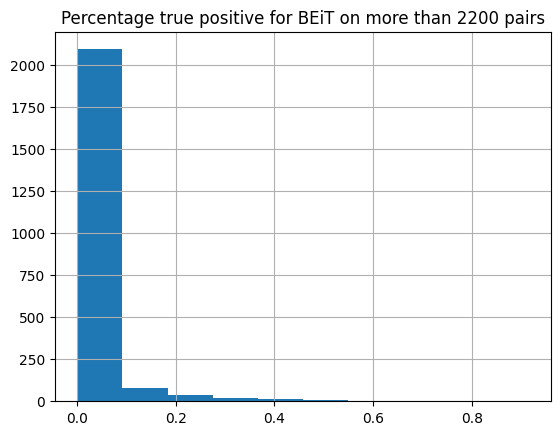

In [30]:
percentiles_results_beit_2200["index_tp"].hist()
plt.title("Percentage true positive for BEiT on more than 2200 pairs")

In [75]:
len(percentiles_results_beit_2200[percentiles_results_beit_2200["index_tp"]<=0.2])/len(percentiles_results_beit_2200)

0.9646174259177355

Text(0.5, 1.0, 'Percentage true positive for VGG on more than 2200 pairs')

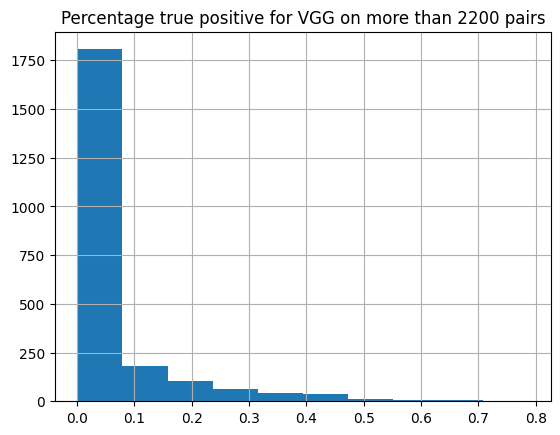

In [54]:
percentiles_results_vgg_2200["index_tp"].hist()
plt.title("Percentage true positive for VGG on more than 2200 pairs")

In [76]:
len(percentiles_results_vgg_2200[percentiles_results_vgg_2200["index_tp"]<=0.2])/len(percentiles_results_vgg_2200)

0.9062361786819991

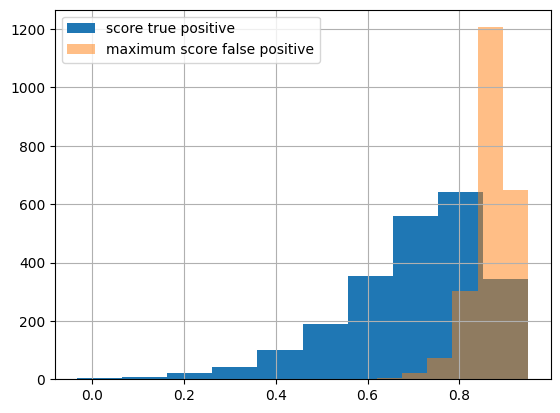

In [31]:
percentiles_results_vit_2200["score_tp"].hist(label="score true positive")
percentiles_results_vit_2200["max_score_fp"].hist(alpha=0.5, label="maximum score false positive")
plt.legend()

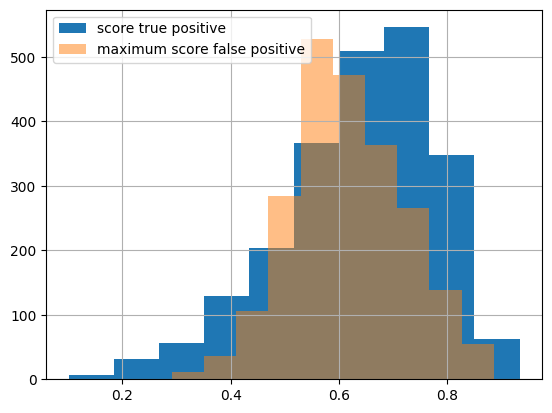

In [33]:
percentiles_results_beit_2200["score_tp"].hist(label="score true positive")
percentiles_results_veit_2200["max_score_fp"].hist(alpha=0.5, label="maximum score false positive")
plt.legend()

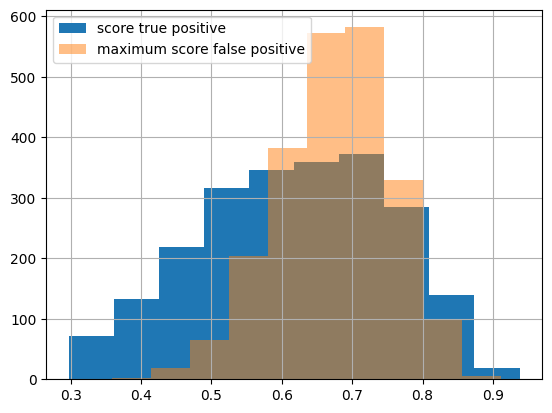

In [55]:
percentiles_results_vgg_2200["score_tp"].hist(label="score true positive")
percentiles_results_vgg_2200["max_score_fp"].hist(alpha=0.5, label="maximum score false positive")
plt.legend()

In [64]:
results_vit_2200_manh = pd.read_csv("/Users/carlalasry/Downloads/results_2200_tps_vit_model_manhattan_dist.csv", index_col=0).T
results_beit_2200_manh = pd.read_csv("/Users/carlalasry/Downloads/results_2200_tps_beit_model_manhattan_dist.csv", index_col=0).T

In [65]:
with open("/Users/carlalasry/Downloads/manhattan_similarity_captures_tps_2200.txt","r") as f:
    scores = f.readlines()
f.close()
with open("/Users/carlalasry/Downloads/crop_names_captures_tps_2200.txt", "r") as f :
    caps_names = f.readlines()
f.close()
with open("/Users/carlalasry/Downloads/crop_names_streams_tps_2200.txt", "r") as f :
    streams_names = f.readlines()
f.close()


caps_filenames = [s.split("\n")[0].split("/")[-1] for s in caps_names]
streams_filenames = [s.split("\n")[0].split("/")[-1] for s in streams_names]

results_vgg_2200 = {}
for cap_filename, row in zip(caps_filenames, scores):
    results_vgg_2200[cap_filename] = {}
    res_cap = [float(i) for i in row.split(" ")]
    for stream_filename, res_stream in zip(streams_filenames, res_cap):
        results_vgg_2200[cap_filename][stream_filename] = res_stream


results_vgg_df_2200_manh = pd.DataFrame(results_vgg_2200).T

In [66]:
results_vit_2200_manh['max'] = results_vit_2200_manh.idxmin(axis=1)
results_beit_2200_manh['max'] = results_beit_2200_manh.idxmin(axis=1)
results_vgg_df_2200_manh['max']= results_vgg_df_2200_manh.idxmin(axis=1)

In [67]:
c_tps_vit, c_fps_vit, res_tps_vit, res_fps_vit = get_number_tps(results_vit_2200_manh)
c_tps_beit, c_fps_beit, res_tps_beit, res_fps_beit = get_number_tps(results_beit_2200_manh)
c_tps_vgg, c_fps_vgg, res_tps_vgg, res_fps_vgg = get_number_tps(results_vgg_df_2200_manh)


In [68]:
print(c_tps_vit/len(results_vit_2200_manh))
print(c_tps_beit/len(results_beit_2200_manh))
print(c_tps_vgg/len(results_vgg_df_2200_manh))

0.0
0.48120300751879697
0.31844316674038037


In [436]:
results_fps_beit = pd.read_csv("/Users/carlalasry/Downloads/results_fps_beit_similarity.csv", index_col=0).T

In [437]:
results_fps_beit.shape

(1286, 1286)

In [438]:
results_fps_beit['max'] = results_fps_beit.idxmax(axis=1)


In [439]:
c_tps_beit_fps, c_fps_beit_fps, res_tps_beit_fps, res_fps_beit_fps = get_number_tps(results_fps_beit)


In [441]:
print(c_tps_beit_fps/len(results_fps_beit))

0.1321928460342146


In [442]:
res_tps_beit_fps

[('1661068671616843800_ID_0-2.jpg',
  '1661068671616843800_1666998809.447.jpg',
  0.6176457745562606),
 ('1674880962070077400_ID_0-6.jpg',
  '1674880962070077400_1670291891.579.jpg',
  0.5382606781689317),
 ('1661043755484004400_ID_0-4.jpg',
  '1661043755484004400_1666992871.232.jpg',
  0.8963722496746102),
 ('1661022475875598300_ID_0-0.jpg',
  '1661022475875598300_1666987712.315.jpg',
  0.7315605265295603),
 ('1661078239226921000_ID_0-3.jpg',
  '1661078239226921000_1667001079.733.jpg',
  0.6246320796555327),
 ('1661070938424295400_ID_0-6.jpg',
  '1661070938424295400_1666999360.016.jpg',
  0.8078600141898191),
 ('1660729240628347000_ID_0-0.jpg',
  '1660729240628347000_1666917890.275.jpg',
  0.7070957799518262),
 ('1660998000358539300_ID_0-5.jpg',
  '1660998000358539300_1666981969.795.jpg',
  0.8264448507194732),
 ('1660765174543478800_ID_0-5.jpg',
  '1660765174543478800_1666926470.032.jpg',
  0.6593916055785987),
 ('1660960022064066600_ID_0-4.jpg',
  '1660960022064066600_1666972916.881